## Imports and loading data

In [69]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction import DictVectorizer

from scipy import sparse

from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k

from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/sample_submission.csv
/kaggle/input/item-features/metadata.csv
/kaggle/input/item-features/products.csv
/kaggle/input/item-features/overall.csv
/kaggle/input/item-features/user_features.csv
/kaggle/input/item-features/item_features.csv


In [70]:
DATA_PATH = '/kaggle/input/recommendationsv4'

# best parameters, found by model optimization (check corresponding function below)
LR = 0.14 # learning rate
NUM_THREADS = 4 # number of threads
NUM_COMPONENTS = 185 # number of vector parameters 
NUM_EPOCHS = 13 # number of learning epochs

In [71]:
train = pd.read_csv(DATA_PATH + '/train.csv', parse_dates=['reviewTime'])
test = pd.read_csv(DATA_PATH + '/test.csv', parse_dates=['reviewTime'], index_col=0)
submission = pd.read_csv(DATA_PATH + '/sample_submission.csv')
# metadata = pd.read_json(DATA_PATH + '/meta_Grocery_and_Gourmet_Food.json', lines=True)
# metadata = pd.read_csv('/kaggle/input/item-features/metadata.csv')
item_features_df = pd.read_csv('/kaggle/input/item-features/item_features.csv', index_col=0)  # metadata, merged with itemids and restructured

## Data observation and EDA

First, let's have a look at some basic characteristics and distribution of our features in train and test datasets.

In [72]:
pd.set_option('display.max_colwidth', 150)

def features_info(data):
    display(pd.concat([pd.DataFrame({'Total':data.shape[0],'Null count, %': round(100*(data.isna().sum()/data.shape[0]),2), 
                      'DType': data.dtypes, 'NUnique': data.nunique(), 
                      'Random sample': list(data.sample(5).T.values)}, index = data.columns), 
              data.describe(include='all').drop(['count', 'unique']).fillna('').T], axis=1))
    
print('Train info:')
features_info(train)
print('Test info:')
features_info(test)

Train info:


,Total,"Null count, %",DType,NUnique,Random sample,top,freq,first,last,mean,std,min,25%,50%,75%,max
overall,857895,0.00,float64,5,"[5.0, 3.0, 5.0, 2.0, 5.0]",,,NaT,NaT,4.4417,1.06466,1,4,5,5,5
verified,857895,0.00,bool,2,"[False, True, True, True, False]",True,745243,NaT,NaT,,,,,,,
reviewTime,857895,0.00,datetime64[ns],4580,"[2014-08-24 00:00:00, 2016-08-07 00:00:00, 2015-09-26 00:00:00, 2016-06-09 00:00:00, 2016-11-07 00:00:00]",2016-03-01 00:00:00,942,2000-08-09,2018-10-02,,,,,,,
asin,857895,0.00,object,41302,"[B007OXJLZQ, B009OLQ9AG, B000HTJPRI, B00F3CWIO6, B0014EQHK8]",B00BUKL666,5491,NaT,NaT,,,,,,,
reviewerName,857895,0.02,object,101207,"[Joyce B., zoe, JiaTian, Jesse Olson, Ervin W. Schrader]",Amazon Customer,31726,NaT,NaT,,,,,,,
reviewText,857895,0.03,object,686739,"[This may be my favorite flavor in decaf. Love it!, When I received these candies, they looked like they had been handled very roughly with no pr...",good,3144,NaT,NaT,,,,,,,
summary,857895,0.02,object,411451,"[Five Stars, Looked bad, Five Stars, Mixed with erythritol, Best bean soup]",Five Stars,173850,NaT,NaT,,,,,,,
unixReviewTime,857895,0.00,int64,4580,"[1408838400, 1470528000, 1443225600, 1465430400, 1478476800]",,,NaT,NaT,1.44176e+09,5.97357e+07,9.65779e+08,1.41195e+09,1.4491e+09,1.48487e+09,1.53844e+09
vote,857895,86.16,object,477,"[nan, 3.0, nan, nan, nan]",2,30887,NaT,NaT,,,,,,,
style,857895,48.20,object,25892,"[nan, nan, nan, {'Size:': ' 1 Pound'}, {'Size:': ' 11.5 Ounce (Pack of 12)', 'Flavor:': ' Healthy Request, Bean with Bacon'}]",{'Size:': ' Pack of 1'},5411,NaT,NaT,,,,,,,


Test info:


,Total,"Null count, %",DType,NUnique,Random sample,top,freq,first,last,mean,std,min,25%,50%,75%,max
reviewTime,285965,0.00,datetime64[ns],4349,"[2017-01-03 00:00:00, 2015-03-21 00:00:00, 2018-04-28 00:00:00, 2015-07-25 00:00:00, 2015-09-02 00:00:00]",2016-03-01 00:00:00,316,2002-06-06,2018-10-02,,,,,,,
asin,285965,0.00,object,37876,"[B004LKVRKM, B00LNURL94, B00PVZQBD4, B00R29LF24, B0053DJYOC]",B00BUKL666,1896,NaT,NaT,,,,,,,
reviewerName,285965,0.02,object,86815,"[Lyle Reynolds, Dan, MEI WONG, JKing, Christina]",Amazon Customer,10642,NaT,NaT,,,,,,,
unixReviewTime,285965,0.00,int64,4349,"[1483401600, 1426896000, 1524873600, 1437782400, 1441152000]",,,NaT,NaT,1.44182e+09,5.95571e+07,1.02332e+09,1.41195e+09,1.4491e+09,1.48487e+09,1.53844e+09
vote,285965,86.20,object,304,"[nan, nan, nan, nan, nan]",2,7959,NaT,NaT,,,,,,,
style,285965,48.36,object,18904,"[{'Size:': ' 2.2 Pounds'}, nan, {'Size:': ' 100 Count'}, nan, nan]",{'Size:': ' Pack of 1'},1826,NaT,NaT,,,,,,,
image,285965,99.17,object,2306,"[nan, nan, nan, nan, nan]","['https://images-na.ssl-images-amazon.com/images/I/81r6ey8uQiL._SY88.jpg', 'https://images-na.ssl-images-amazon.com/images/I/81S+pwiS+RL._SY88.jpg']",3,NaT,NaT,,,,,,,
userid,285965,0.00,int64,109357,"[63838, 48165, 3737, 69791, 15199]",,,NaT,NaT,54435.4,36760.1,0,21829,49833,84785,127495
itemid,285965,0.00,int64,37876,"[13780, 29628, 31676, 31987, 15120]",,,NaT,NaT,17083.4,11427.6,0,6329,15956,26615,41319
Id,285965,0.00,int64,285965,"[52393, 36816, 12864, 9443, 249016]",,,NaT,NaT,142982,82551.1,0,71491,142982,214473,285964


Now we can move to more indepth analisys.

In [73]:
users_interactions_count = train.groupby(['userid', 'itemid']).size().groupby('userid').size()
print(f'Our data consists of {len(users_interactions_count)} unique users.')
users_with_enough_interactions = users_interactions_count[users_interactions_count >= 5].reset_index()[['userid']]
print(f'Among them there are {len(users_with_enough_interactions)} users with at least 5 interactions.')

Our data consists of 127448 unique users.
Among them there are 74571 users with at least 5 interactions.


Some customers may have several names.

In [74]:
# checking if there are users with several names
users_with_several_names = train.groupby('userid').filter(lambda x: x['reviewerName'].nunique() > 1)
users_with_several_names.groupby(['userid','reviewerName']).size()[:10]

userid  reviewerName   
15      Lou                 4
        Lou S. Hegwer       3
49      BBarath             7
        R. Barath          18
100     NancyM              1
        Penny Gname         5
131     Amazon Customer     2
        SC                  1
151     adjsbb             11
        bixbyhelo           1
dtype: int64

But most of them are anonymous (either Amazon or Kindle Customer).

In [75]:
train['reviewerName'].value_counts()

Amazon Customer    31726
Kindle Customer     6228
Linda                734
John                 725
David                619
                   ...  
Melodi Blanton         1
Kim12354               1
Ricky W.               1
sandy pyle             1
Laura A. Henyan        1
Name: reviewerName, Length: 101207, dtype: int64

In [76]:
item_interactions_count = train.groupby(['itemid', 'userid']).size().groupby('itemid').size()
print(f'We have {len(item_interactions_count)} unique products in the dataset.')
items_with_enough_interactions = item_interactions_count[item_interactions_count >= 5].reset_index()[['itemid']]
print(f'{len(items_with_enough_interactions)} products were rated by at least 5 customers.')

We have 41302 unique products in the dataset.
33018 products were rated by at least 5 customers.


Let's check what we can find out about the products we are dealing with.
We have a whole big dataset with metadata for this purpose.

In [77]:
features_info(item_features_df)

,Total,"Null count, %",DType,NUnique,Random sample,top,freq,mean,std,min,25%,50%,75%,max
itemid,164244,0.00,int64,41320,"[35640, 11306, 14144, 32844, 27205]",,,20645.8,11897.9,0,10324.8,20658.5,30920,41319
category,164244,0.00,object,1003,"[Candy & Chocolate, Bottled Beverages, Water & Drink Mixes, Grocery & Gourmet Food, Brittle, Caramel & Toffee, Cereals]",Grocery & Gourmet Food,41320,,,,,,,
category_id,164244,0.00,int64,1003,"[138, 91, 425, 111, 164]",,,416.437,247.176,0,228,425,541,1002
asin,164244,0.00,object,41320,"[B016CSVGVU, B0034L8UWM, B004SKITGU, B00U3WX0J8, B00HZVW7T4]",B013I1KEV2,11,,,,,,,
description,164244,8.25,object,36544,"[nan, [""Lean Body On the Go! Shakes provide quick, delicious lean muscle nutrition for active people. Just twist open and enjoy Lean Body's smooth...","['Our mission is to be the leader in importing and marketing superior quality specialty foods under our Roland brand and other brands, and to perf...",204,,,,,,,
title,164244,0.00,object,41167,"[Goetze's Caramel Creams, 5 LB Bulk Candy, Labrada Nutrition Lean Body On the Go Ready to Drink, Vanilla Ice Cream, 14-Ounce, Pack of 12, Snickers...",Great Low Carb Bread Co. - Plain - 1 Loaf,20,,,,,,,
price,164244,38.58,object,4603,"[$23.99, nan, $18.16, $20.38, nan]",$14.99,2324,,,,,,,
main_cat,164244,0.20,object,17,"[Grocery, Health & Personal Care, Grocery, Grocery, Grocery]",Grocery,155406,,,,,,,
image,164244,19.71,object,32770,"[['https://images-na.ssl-images-amazon.com/images/I/61g8UIRYuGL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51bk6RvBgcL._SS40_....","['https://images-na.ssl-images-amazon.com/images/I/516i4F6B5hL._SS40_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51Gqln7mZkL._SS40_.j...",94,,,,,,,


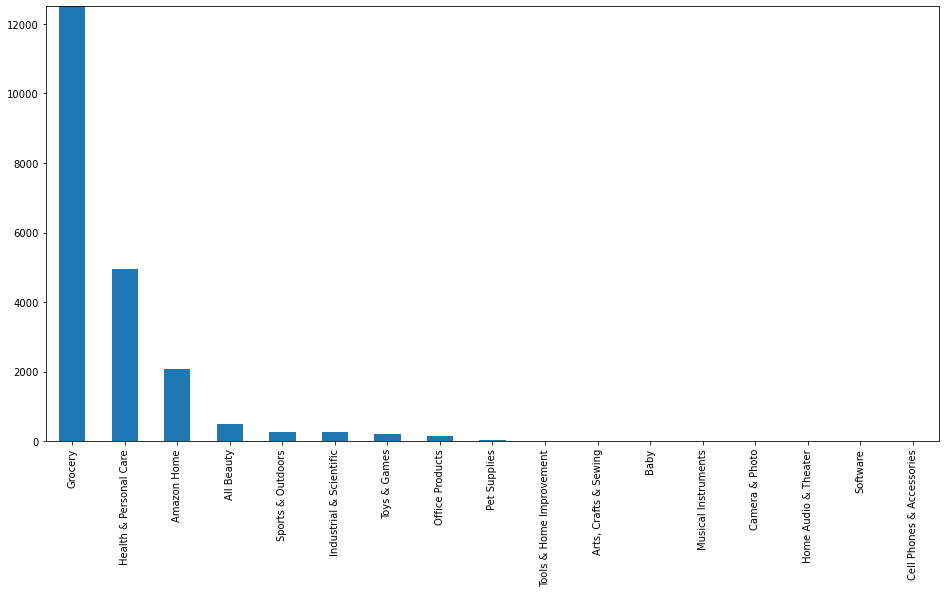

In [78]:
plt.figure(figsize=(16,8))
plt.ylim(0,12500)
item_features_df['main_cat'].value_counts().plot(kind='bar');

Most of the products belong to grocery, with very little of other categories involved.

Here are ten most popular items.

In [79]:
item_features_df.groupby('itemid')['title'].value_counts().sort_values(ascending=False)[:10]

itemid  title                                                                                                                    
34946   LaCroix Sparkling Water, Coconut Flavor, 12oz Cans, 8 Pack, Naturally Essenced Flavor, 0 Calories, 0 Sweeteners, 0 Sodium    11
2595    Season Black Capelin Caviar from Iceland, 3.5-Ounce Glass Jars (Pack of 4)                                                   10
1136    BACKPACKER'S PANTRY Louisiana Beans and Rice                                                                                 10
34893   Banza Chickpea Pasta – High Protein Gluten Free Healthy Pasta - Pack of 6                                                     9
28767   True Peach Lemonade Drink Mix, 10-count (Pack of 4) with 5 FREE Lemonade Sample Sticks                                        6
19611   Grape Crush Sugar Free Singles to Go ! Box of 6 Packets (6-Pack)                                                              6
28762   True Black Cherry Limeade Drink Mix, 10-count 

In our dataset we have more samples of positive rating then negative, and most of reviews are verified.

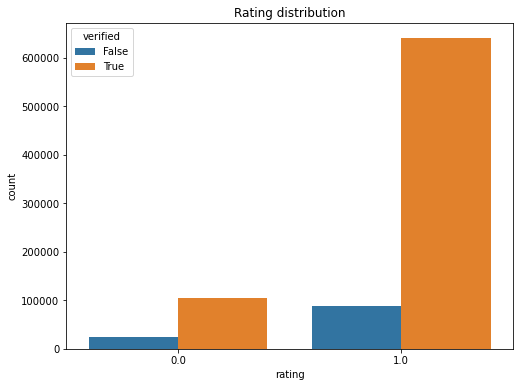

In [80]:
plt.figure(figsize=(8,6))
sns.countplot(train['rating'], hue = train['verified'])
plt.title('Rating distribution');


Dates of oldest and earliest review:


In [81]:
print(f"The oldest: {train['reviewTime'].min():%d.%m.%Y}")
print(f"The newest: {train['reviewTime'].max():%d.%m.%Y}")

The oldest: 09.08.2000
The newest: 02.10.2018


Positive reviews are very easy to identify by review text, at the same time negative ones inculed many odd words. They are easier to detect using summary.

Based on review text:


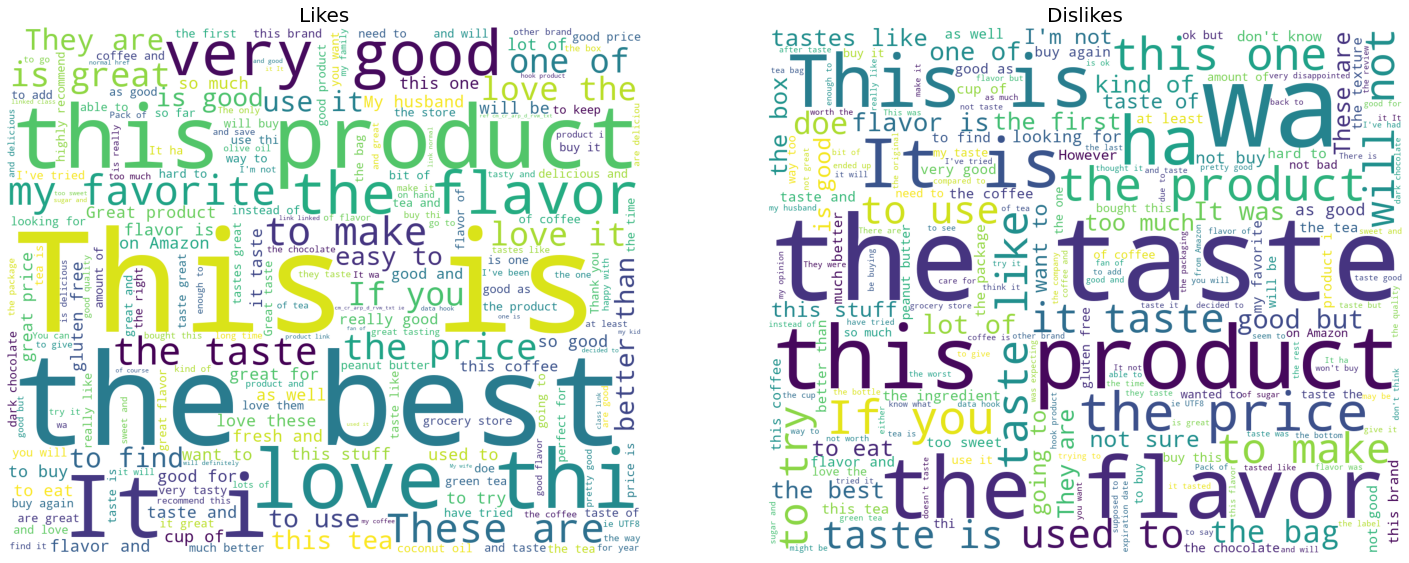

In [82]:
# This is not bad
print('Based on review text:')
train['reviewText'].fillna('noreview', inplace=True)

likes = ' '.join(i for i in train.query('rating==1')['reviewText'])
dislikes = ' '.join(i for i in train.query('rating==0')['reviewText'])
cloud = WordCloud(background_color="white", width=1200, height=1000)
plt.figure(figsize=(25,15))
i = 0
for rew_type, title in zip([likes, dislikes], ['Likes', 'Dislikes']):
    i += 1
    plt.subplot(1,2,i)
    img = cloud.generate(rew_type)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.imshow(img);

Based on summary:


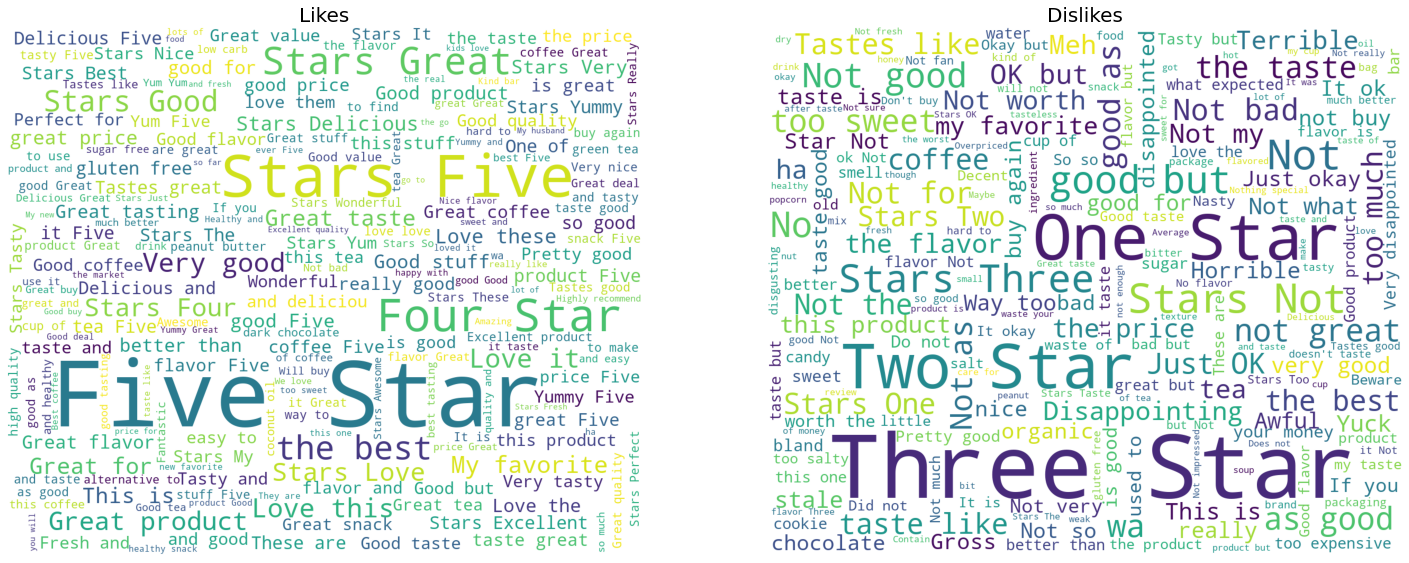

In [83]:
# But this one is more obvious in any way
print('Based on summary:')
train['summary'].fillna('noreview', inplace=True)

likes = ' '.join(i for i in train.query('rating==1')['summary'])
dislikes = ' '.join(i for i in train.query('rating==0')['summary'])
cloud = WordCloud(background_color="white", width=1200, height=1000)
plt.figure(figsize=(25,15))
i = 0
for rew_type, title in zip([likes, dislikes], ['Likes', 'Dislikes']):
    i += 1
    plt.subplot(1,2,i)
    img = cloud.generate(rew_type)
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.imshow(img);

There could be some multistyle products. So, is there any difference in rating between one style and the other in general and for the same user?

In [84]:
multistyle = train.groupby('itemid').filter(lambda x:x['style'].nunique() > 1)
print('Mean rating by style: \n')
display(multistyle.groupby(['itemid', 'style'])['rating'].mean())

Mean rating by style: 



itemid  style                                                                                   
6       {'Scent Name:': ' Green Tea with Echinacea'}                                                0.857143
        {'Scent Name:': ' Original Swiss Herb'}                                                     0.833333
9       {'Size:': ' 12 Ounce (Pack of 6)'}                                                          0.838710
        {'Size:': ' 24 Count/1.75 Ounce'}                                                           1.000000
        {'Size:': ' 7 Ounce (Pack of 12)'}                                                          1.000000
                                                                                                      ...   
41313   {'Size:': ' 17 Ounce ( pack of 8 )', 'Flavor:': ' Hearty Corn & Chipotle Chowder'}          1.000000
        {'Size:': ' 17 Ounce ( pack of 8 )', 'Flavor:': ' Hearty Lentil with Garden Vegetables'}    1.000000
        {'Size:': ' 17 oz', 'Fl

In [85]:
users_rate_style = multistyle.groupby(['userid', 'itemid']).filter(lambda x: (x['style'].nunique() > 1)&(x['rating'].mean()<1)&(0 < x['rating'].mean()))
print('Mean rating by style from the same customer: \n')
users_rate_style.groupby(['userid', 'itemid', 'style'])['rating'].mean()[:10]

Mean rating by style from the same customer: 



userid  itemid  style                                                      
104     11881   {'Flavor:': ' Slightly Sweet'}                                 0.0
                {'Flavor:': ' Vanilla'}                                        1.0
269     4790    {'Flavor:': ' Cheese Manicotti'}                               0.0
                {'Flavor:': ' Chicken Breast & Dressing'}                      1.0
318     12      {'Size:': ' Pack of 12', 'Flavor:': ' Mixed Berry Blast'}      0.0
                {'Size:': ' Pack of 24', 'Flavor:': ' Chocolate'}              1.0
326     2280    {'Flavor:': ' Honey Stung'}                                    0.0
                {'Flavor:': ' Mild'}                                           1.0
355     25045   {'Size:': ' 5 Ounce', 'Flavor:': ' Garlic Olive Oil'}          1.0
                {'Size:': ' 5 Ounce', 'Flavor:': ' Mediterranean Sea Salt'}    0.0
Name: rating, dtype: float64

## LightFM

Now we know enough and are ready to build our model and make reccommendations. 

Here we implement time decay as model sample weights.

In [86]:
oldest_review = train['reviewTime'].min()
train['weights'] = (train['reviewTime'] - oldest_review).dt.days + 1
train['weights'] = (train['weights'] - train['weights'].min())/(train['weights'] - train['weights'].min()).max()
train['weights'].min(), train['weights'].max()

(0.0, 1.0)

We also tried to implement item features to the model, constructing them, as follows: 
```
item_features = sparse.csr_matrix(([1]*len(item_features_df), (item_features_df['itemid'], item_features_df['category_id'])))
```
And adding in both learning and prediction parts:
```
model = model.fit(ratings_coo, 
                 sample_weight = sample_weights, 
                 item_features=item_features,
                  epochs=EPOCHS, 
                  num_threads=NUM_THREADS)
preds = model.predict(test_data['userid'].values,
                      test_data['itemid'].values,
                      item_features=item_features)
```
But so far they haven't improved the result, and even worsen it. So, it seems, further investigation is needed in this field.

Preparing data for validation.

In [87]:
train_data, test_data = train_test_split(train,random_state=32, shuffle=True)

ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))
sample_weights = sparse.coo_matrix((train_data['weights'], (train_data['userid'],
                                  train_data['itemid'])))

In [93]:
# preparing data for sumbission
# ratings_coo = sparse.coo_matrix((train['rating'].astype(int),
#                                  (train['userid'],
#                                   train['itemid'])))
# sample_weights = sparse.coo_matrix((train['weights'], (train['userid'],
#                                   train['itemid'])))

And train the model.

In [ ]:
model = LightFM(learning_rate=LR, 
                loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, 
                 sample_weight = sample_weights, 
                  epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

model.item_biases *= 1.0

Final results are not bad... at least ROC AUC score.


In [89]:
preds = model.predict(test_data['userid'].values,
                      test_data['itemid'].values)
print(f'Test auc: {roc_auc_score(test_data.rating,preds)}')

Test auc: 0.7539242325216182


In [90]:
print(f'Train precision:  {round(precision_at_k(model, ratings_coo, k=5).mean(),2)}')
print(f'Train recall: {round(recall_at_k(model, ratings_coo, k=5).mean(),2)}')

Train precision:  0.05999999865889549
Train recall: 0.07


So, we can proceed with submitting to the competition and getting embedings to make recommendations.

In [ ]:
preds = model.predict(test.userid.values,
                      test.itemid.values)

preds.min(), preds.max()

In [ ]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds.min(), normalized_preds.max()

In [ ]:
submission['rating']= normalized_preds
submission = submission.set_index('Id')
submission.head()

In [ ]:
submission.to_csv('submission_LightFM.csv')

In [ ]:
item_biases, item_embeddings = model.get_item_representations()
import pickle
with open('item_embeddings.pickle', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

### Optimization



In [ ]:
import itertools

def sample_hyperparameters():
    '''
    Yields sets of random hyperparameters
    '''

    while True:
        yield {
            "no_components": np.random.randint(10, 200),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "learning_rate": np.random.exponential(0.05),
            "num_epochs": np.random.randint(5, 200)
        }


def random_search(train, test, weights, num_samples=10, num_threads=4):
    
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, sample_weight = sample_weights,
                  item_features=item_features,epochs=num_epochs, 
                  num_threads=num_threads)
        model.item_biases *= 1.0
        preds = model.predict(test_data['userid'].values,
                      test_data['itemid'].values, item_features=item_features)
        score = roc_auc_score(test_data.rating,preds)
        print(score)
        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)          

(score, hyperparams, model) = max(random_search(ratings_coo, test_data, sample_weights, num_samples=50), key=lambda x: x[0])

print(f"Best score {score} at {hyperparams}")

```
Best score 0.7539169181446421 at {'no_components': 185, 
                                  'learning_schedule': 'adagrad', 
                                  'learning_rate': 0.14077551443506026, 
                                  'num_epochs': 13}
```